In [11]:
!C:\Users\toy_3\AppData\Local\Programs\Python\Python39\python.exe -m pip install geopandas

   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/16.2 MB 4.8 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/16.2 MB 3.1 MB/s eta 0:00:05
   --- ------------------------------------ 1.3/16.2 MB 1.9 MB/s eta 0:00:08
   --- ------------------------------------ 1.3/16.2 MB 1.9 MB/s eta 0:00:08
   --- ------------------------------------ 1.6/16.2 MB 1.5 MB/s eta 0:00:10
   --- ------------------------------------ 1.6/16.2 MB 1.5 MB/s eta 0:00:10
   ---- ----------------------------------- 1.8/16.2 MB 1.3 MB/s eta 0:00:12
   ---- ----------------------------------- 1.8/16.2 MB 1.3 MB/s eta 0:00:12
   ----- ---------------------------------- 2.1/16.2 MB 1.1 MB/s eta 0:00:13
   ----- ---------------------------------- 2.1/16.2 MB 1.1 MB/s eta 0:00:13
   ----- ---------------------------------- 2.4/16.2 MB 1.0 MB/s eta 0:00:14
   ----- ---------------------------------- 2.4/16.2 MB 1.0 MB/s eta 0:00:14
   ---

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


In [ ]:

result = pd.read_csv("actual_pred_3.csv")
#print(result)
result = result.drop(columns=['MONTH'])


result_by_district = result.groupby(['PROV', 'AMP'], as_index = False).agg(
    Actual_mean = ('caseper100k', 'mean'),
    Pred_mean = ('Pred', 'mean'),
    MAE = ('Pred', lambda x: (x - result.loc[x.index, 'caseper100k']).abs().mean())
)
#print(result_by_district)
result_by_district.isna().any().any()
result_by_district.describe()

,Actual_mean,Pred_mean,MAE
count,895.000000,895.000000,895.000000
mean,0.025780,0.065668,0.064623
std,0.086649,0.103537,0.099651
min,0.000000,-0.000258,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.013919,0.023438
75%,0.020895,0.095949,0.095341
max,1.504417,0.730451,1.256371


In [15]:

gdf = gpd.read_file("districts.shp")
print(gdf)

     Shape_Leng  Shape_Area               ADM2_EN          ADM2_TH ADM2_PCODE  \
0      1.586084    0.076228  Mueang Amnat Charoen  เมืองอำนาจเจริญ     TH3701   
1      1.354140    0.049732              Chanuman          ชานุมาน     TH3702   
2      1.070705    0.041826   Pathum Ratchawongsa      ปทุมราชวงศา     TH3703   
3      0.963642    0.020657                 Phana              พนา     TH3704   
4      1.161007    0.030559       Senangkhanikhom       เสนางคนิคม     TH3705   
..          ...         ...                   ...              ...        ...   
923    1.092145    0.026282                Pa Tio          ป่าติ้ว     TH3505   
924    0.895482    0.035455       Maha Chana Chai        มหาชนะชัย     TH3506   
925    0.805924    0.015913              Kho Wang           ค้อวัง     TH3507   
926    1.952979    0.075634         Loeng Nok Tha         เลิงนกทา     TH3508   
927    1.179603    0.023212          Thai Charoen         ไทยเจริญ     TH3509   

           ADM1_EN     ADM1

In [ ]:
gdf['PROV'] = gdf['ADM1_EN'].str.lower().str.strip()
gdf['AMP'] = gdf['ADM2_EN'].str.lower().str.strip()

result_by_district['PROV'] = result_by_district['PROV'].str.lower().str.strip()
result_by_district['AMP'] = result_by_district['AMP'].str.lower().str.strip()

merged = gdf.merge(result_by_district[['PROV', 'AMP', 'Actual_mean', 'Pred_mean']], on = ['PROV', 'AMP'])

#print(merged)


In [46]:
def plot_heatmap(gdf, column, title = 'Heatmap',
                  cmap = 'Reds', figsize = (10, 12),
                  legend_label = None,
                  save_path = None, dpi = 300):
    if legend_label is None:
        legend_label = column
    
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    gdf.plot(
        column = column,
        cmap = cmap,
        edgecolor = 'black',
        legend = True,
        legend_kwds = {'label' : legend_label, 'orientation': 'vertical'},
        ax = ax
    )

    ax.set_title(title, fontsize = 14)
    ax.axis('off')
    if save_path:
        plt.savefig(save_path, dpi = dpi, bbox_inches = 'tight')
    plt.show

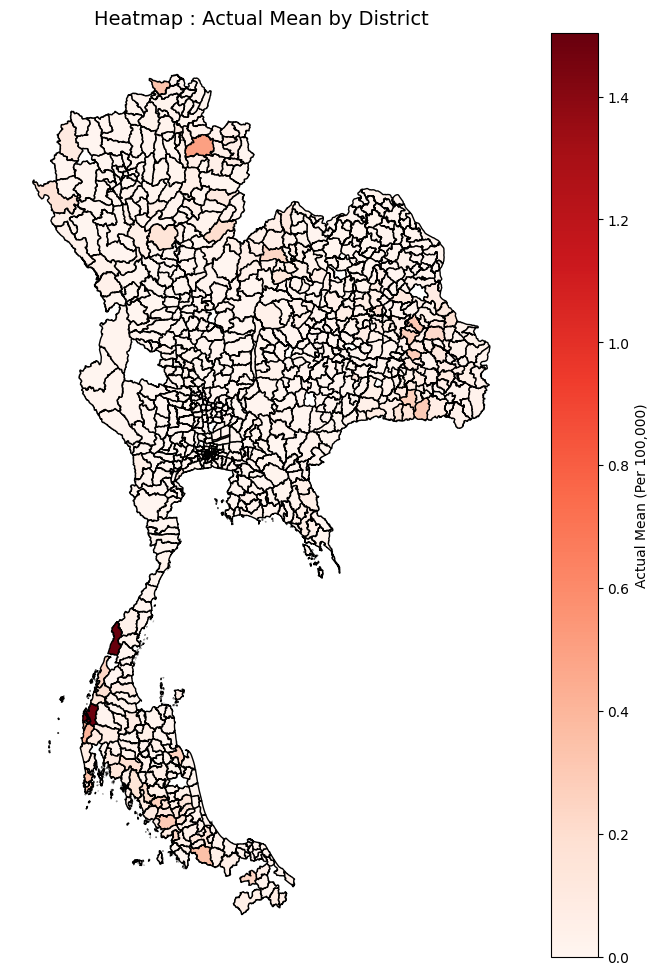

In [47]:
plot_heatmap(merged,
             column = 'Actual_mean',
             title = 'Heatmap : Actual Mean by District',
             cmap = 'Reds',
             legend_label = 'Actual Mean (Per 100,000)',
             save_path = 'Actual_mean.png')

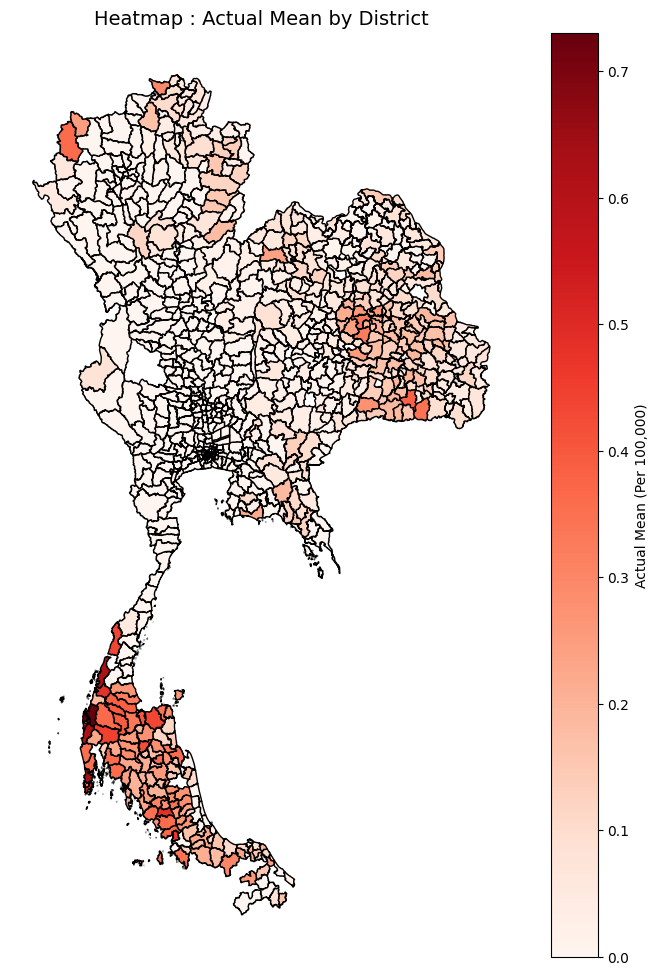

In [48]:
plot_heatmap(merged,
             column = 'Pred_mean',
             title = 'Heatmap : Actual Mean by District',
             cmap = 'Reds',
             legend_label = 'Actual Mean (Per 100,000)',
             save_path = 'Pred_mean.png')